(scrna_seq_workflow)=

## Precaching normalized values for faster gene query and marker search

This workflow shows how to use `save_normed_for_query` function to create a cache of genes. This cache substantially improves the runtime of `run_marker_search` and also when querying for multiple genes. The precaching is a one time process for a dataset and can speed up all subsequent marker search steps.

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.19.4'

time: 1.28 s (started: 2022-04-20 23:35:19 +02:00)


In [2]:
scarf.fetch_dataset(
    'zheng_69K_pbmc_rnaseq',
    save_path='scarf_datasets'
)

time: 25.7 s (started: 2022-04-20 23:35:20 +02:00)


In [3]:
reader = scarf.CrDirReader('scarf_datasets/zheng_69K_pbmc_rnaseq')
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/zheng_69K_pbmc_rnaseq/data.zarr',
    chunk_size=(1000, 1000)
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 45.6 s (started: 2022-04-20 23:35:46 +02:00)


(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

INFO: 2311 cells flagged for filtering out using attribute RNA_nCounts
INFO: 2435 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 1391 cells flagged for filtering out using attribute RNA_percentMito
INFO: 2678 cells flagged for filtering out using attribute RNA_percentRibo


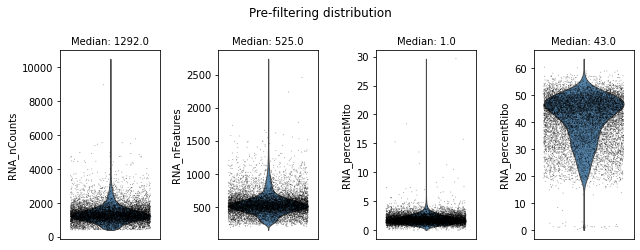

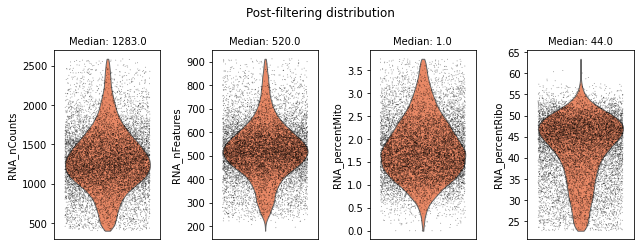

(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 500 genes marked as HVGs


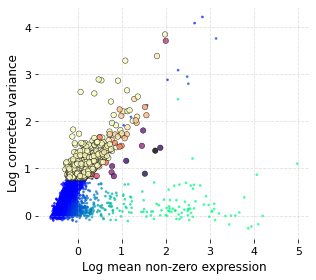

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.14%
time: 2min 54s (started: 2022-04-20 23:36:31 +02:00)


In [4]:
ds = scarf.DataStore(
    'scarf_datasets/zheng_69K_pbmc_rnaseq/data.zarr',
    nthreads=4,
    min_features_per_cell=10
)
ds.auto_filter_cells()
ds.mark_hvgs(
    min_cells=20,
    top_n=500,
    min_mean=-3,
    max_mean=2,
    max_var=6
)
ds.make_graph(
    feat_key='hvgs',
    k=11,
    dims=15
)
ds.run_leiden_clustering(resolution=0.5)

In [6]:
ds.run_marker_search(
    group_key='RNA_leiden_cluster',
    threshold=0.25,
)

Finding markers:   0%|                                                                                        …

time: 4min 36s (started: 2022-04-20 23:39:26 +02:00)


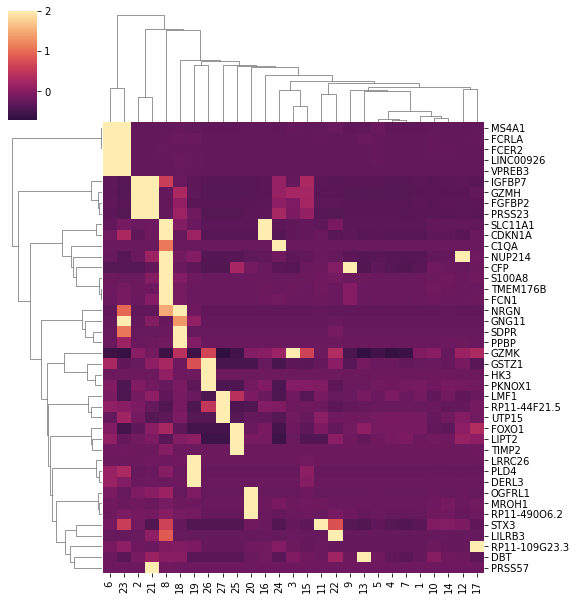

time: 7.31 s (started: 2022-04-20 23:44:03 +02:00)


In [7]:
ds.plot_marker_heatmap(group_key="RNA_leiden_cluster", topn=3)

### Pre-caching normalized expression for fast query

In [8]:
ds.RNA.save_normed_for_query('I', batch_size=100)

Saving features:   0%|                                                                                        …

time: 2min 47s (started: 2022-04-20 23:44:10 +02:00)


### Marker search with precached data

In [9]:
ds.run_marker_search(
    group_key='RNA_leiden_cluster',
    threshold=0.25,
    use_prenormed=True
)

Finding markers:   0%|                                                                                        …

time: 44.5 s (started: 2022-04-20 23:46:57 +02:00)


### The marker search is almost 500% faster with precaching

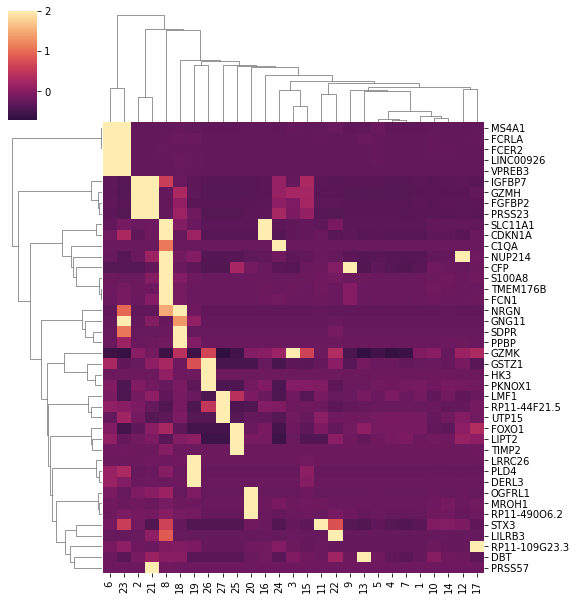

time: 7.86 s (started: 2022-04-20 23:47:42 +02:00)


In [10]:
ds.plot_marker_heatmap(group_key="RNA_leiden_cluster", topn=3)

The heatmaps clearly show that the marker search performed with and without `use_prenormed` parameter lead to same output

---
That is all for this vignette.